# Wavelet compression

Here we describe the general idea of wavelet-pyramid-based compression.


**WARNING: ignore the "error =" values in the wavelet-tree plots. I'm not sure if this is a good way to calculate it and I'll fix that, soon.**

## Preparation

In [4]:
include("../julia/lib.jl")
include("../julia/img.jl")
include("../julia/pruning_test.jl")
using Gadfly
using DataFrames

set_default_plot_size(25cm, 15cm)

map_i2s, map_s2i = loadmap("../data/final.map")
n = length(map_i2s)
m = 256
data = loaddata("../data/v0.data", m, n)

year_first = 1753
t = collect(year_first:(year_first + m - 1))
print()

In [2]:
ngrams_wavelet_demo = ["know", "kiss", "kind", "keep"]

4-element Array{ASCIIString,1}:
 "know"
 "kiss"
 "kind"
 "keep"

## General Idea

For this document, "wavelet" usually refers to "Haar wavelet". This does not limit the general algorithm but we haven't tested any other wavelet type so far.

The following steps are done to build up a tree structure:

1. gathering input $x$ from database
2. calculate $x' = \log(x + 1)$
3. normalize data by $\sum x'$ to $y$
4. transform $y$ into a wavelet pyramid
5. trait the pyramid as a tree structure (w/o the delta-entry aka super-root)

The algorithm is a bottum-up approach (greedy) and prunes (i.e. setting the coefficient to $0$) sub-tries of the tree up to a certain threshold as followed:

```
function prune_tree(theshold)
    for layer in bottom:top            // top = root node
        nodes = nodes_in_layer(layer)
        shuffle(nodes)
        sort(nodes, by=coefficient)    // that prevents us from certain jumps in the graph

        for node in nodes
            theshold -= prune_node(threshold)
        end
    end
end

function prune_node(threshold)
    costs = ...
    
    if pruned?(left) and pruned?(right) and costs < threshold
        prune?(this) = true
        coefficient  = 0
        return costs
    end
end
```

Notations:

- $l$ current level, starting at $1$ for the root node
- $d$ depth of the tree
- $\mathrm{coefficient}$ wavelet coefficient of current node
- $\mathrm{influence} = 2^{d - l + 1}$ influence of the current $\mathrm{coefficient}$ (**TODO: proof + other wavelet types**)
- $\mathrm{costs} = \left|\mathrm{coefficient}\right| \sqrt{\mathrm{influence}}$ costs when this node is pruned

Below you find a pruning example:

In [5]:
plot_wavelet_report(data, map_s2i, year_first, "kiss", 0.01)

LoadError: LoadError: ArgumentError: dimension 1 not supported
while loading In[5], in expression starting on line 1

## Selecting compression threshold

In [18]:
function map_to_compression(thresholds, ng, sorting)
    compression_rates = []
    for t in thresholds
        x = convert(Array{Float64}, data[:,map_s2i[ng]])
        _, _, _, xt_compressed = do_wavelet_pruning(x, t, 0, sorting)
        counter = count(e -> abs(e) > 0, xt_compressed)
        push!(compression_rates, counter / m)
    end
    return compression_rates
end

function print_compression_report(thresholds, y_ticks, sorting=2)
    x_min = minimum(thresholds)
    x_max = maximum(thresholds)
    x_range = x_max - x_min
    if sorting == 2
        dfs_0 = map(ng -> DataFrame(x=thresholds, y=map_to_compression(thresholds, ng, false), label=@sprintf("%s (unsorted)", ng)), ngrams_wavelet_demo)
        df_0 = reduce(vcat, DataFrame(), dfs_0)
        dfs_1 = map(ng -> DataFrame(x=thresholds, y=map_to_compression(thresholds, ng, true), label=@sprintf("%s (sorted)", ng)), ngrams_wavelet_demo)
        df_1 = reduce(vcat, DataFrame(), dfs_1)
        df = vcat(df_0, df_1)
        title = "Compression report (compare)"
    else
        dfs = map(ng -> DataFrame(x=thresholds, y=map_to_compression(thresholds, ng, sorting), label=ng), ngrams_wavelet_demo)
        df = reduce(vcat, DataFrame(), dfs)
        if sorting
            title = "Compression report (sorted)"
        else
            title = "Compression report (unsorted)"
        end
    end
    Gadfly.plot(
        df,
        x="x",
        y="y",
        color="label",
        Geom.line,
        Guide.xlabel("threshold"),
        Guide.ylabel("compression rate"),
        Guide.colorkey("ngram"),
        Guide.title(title),
        Guide.xticks(ticks=collect(x_min:(x_range / 10):x_max)),
        Guide.yticks(ticks=y_ticks),
#        Scale.x_log10,
#        Scale.y_log10
    )
end

print()

### No sorting

First let's investigate what would happen without the sort step described above. "Compression rate" is measured in number of tree nodes that are left after the pruning.

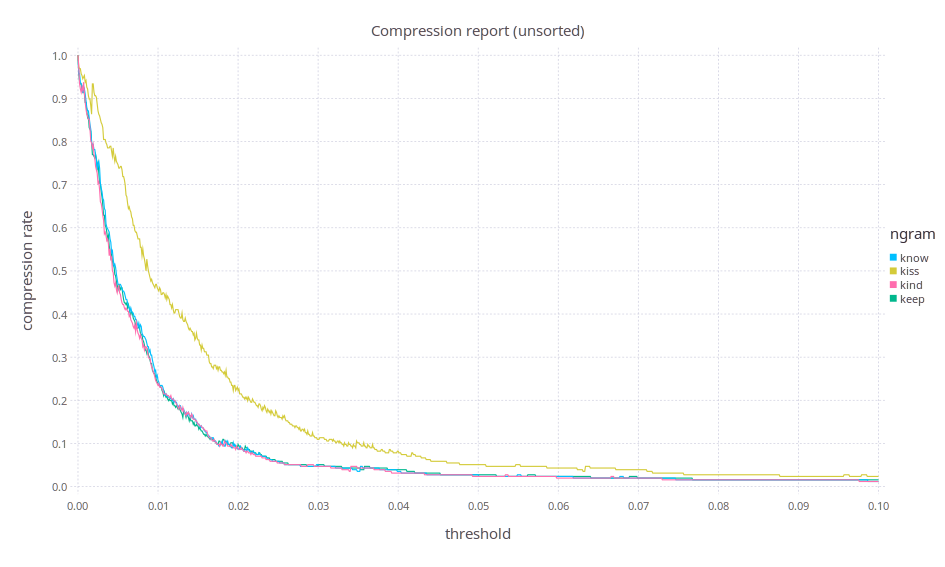

In [19]:
print_compression_report(collect(0:0.0001:0.1), collect(0:0.1:1), false)

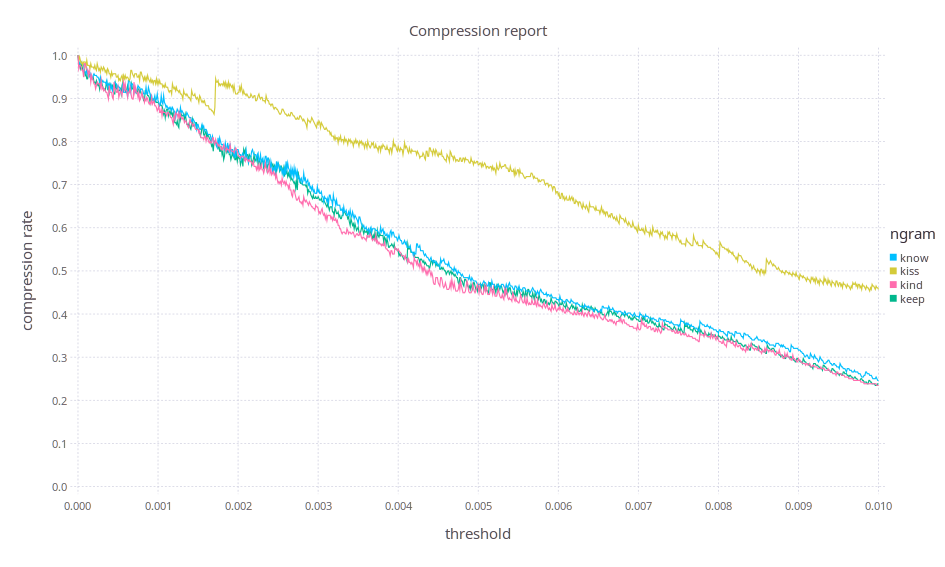

In [6]:
print_compression_report(collect(0:0.00001:0.01), collect(0:0.1:1), false)

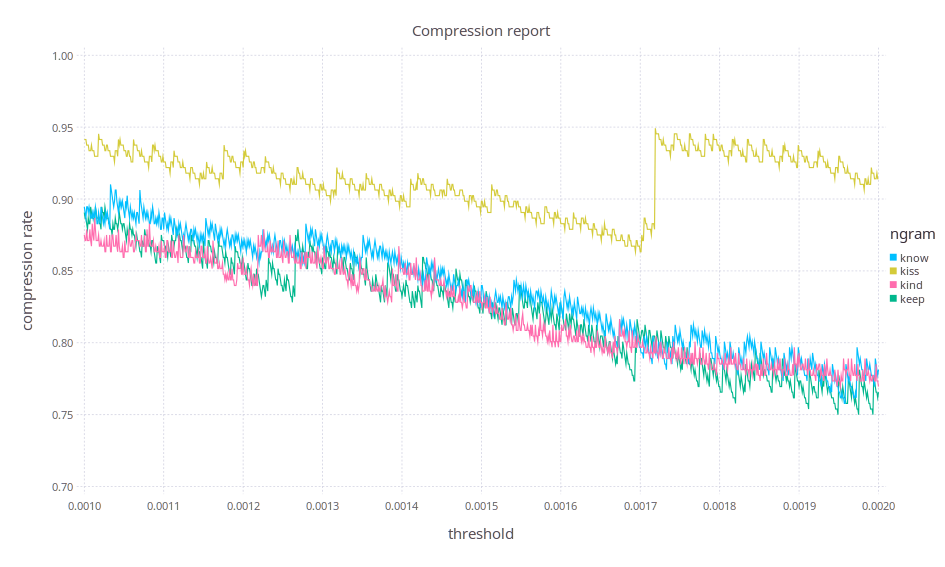

In [7]:
print_compression_report(collect(0.001:0.000001:0.002), collect(0.7:0.05:1), false)

Note the jump of the "kiss" curve around 0.0017. Here is the tree pruning before and after that specific threshold:

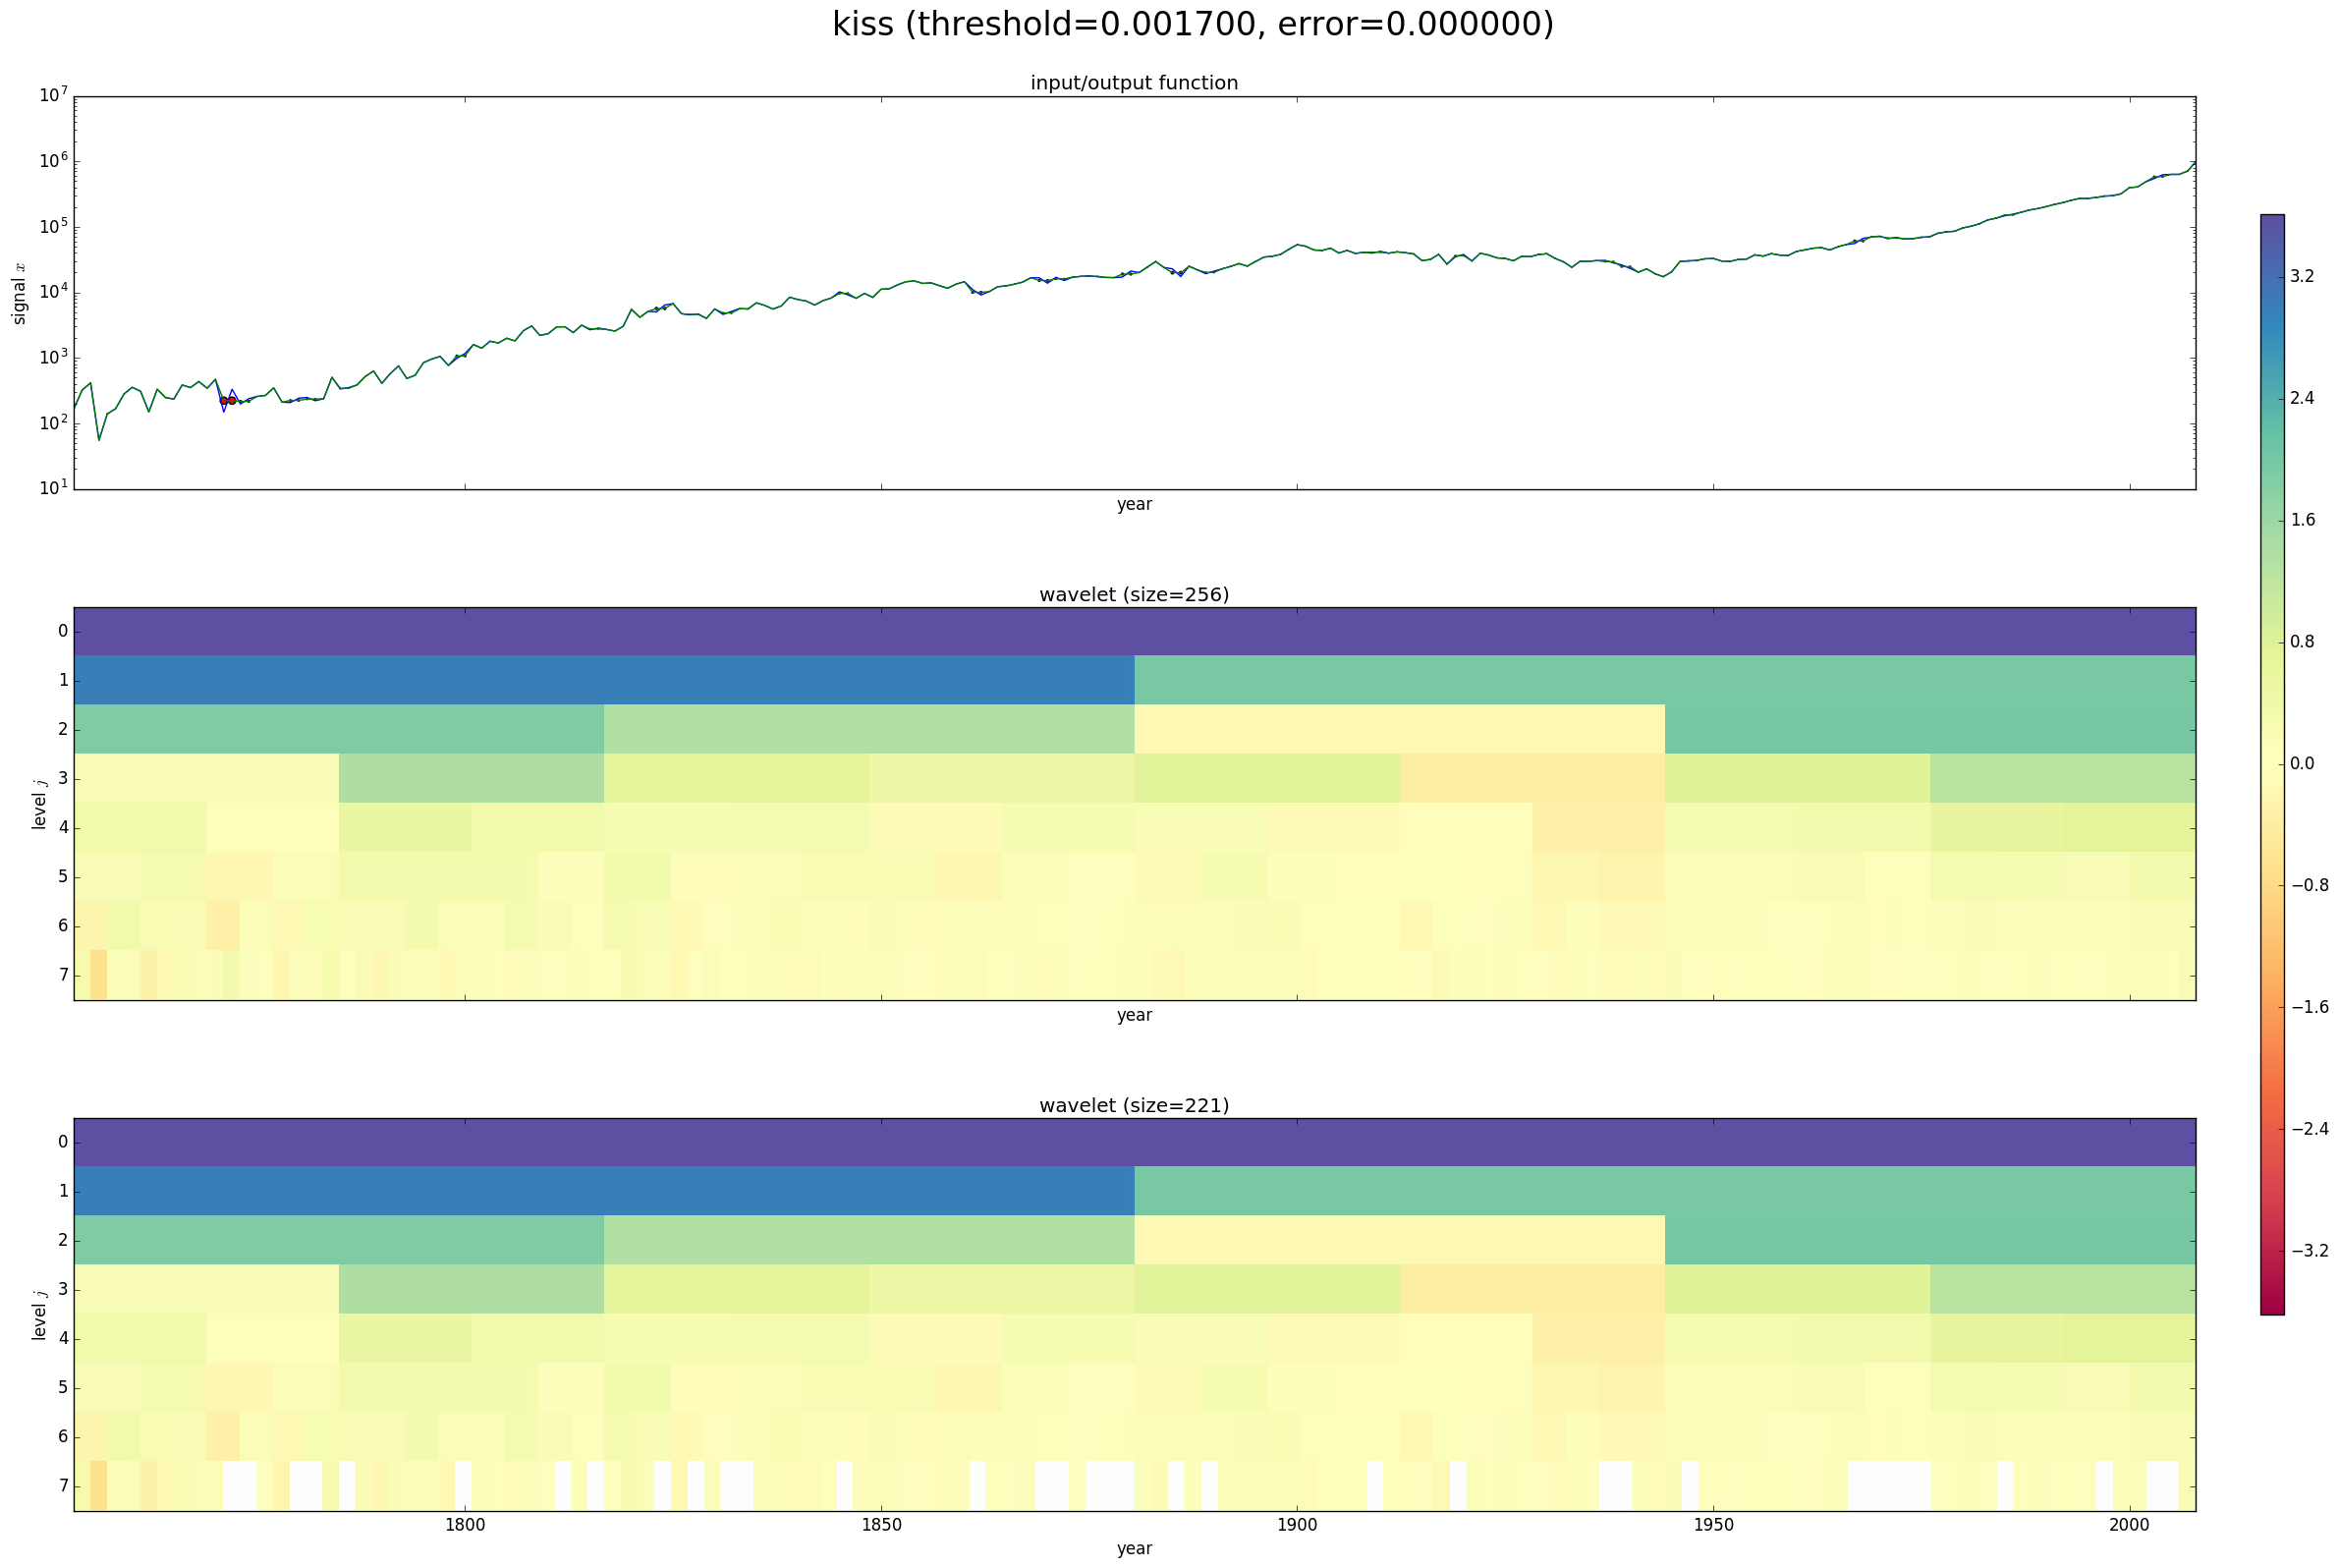

PyObject <matplotlib.text.Text object at 0x7f1faa64b710>

In [8]:
plot_wavelet_report(data, map_s2i, year_first, "kiss", 0.0017, 0, false)

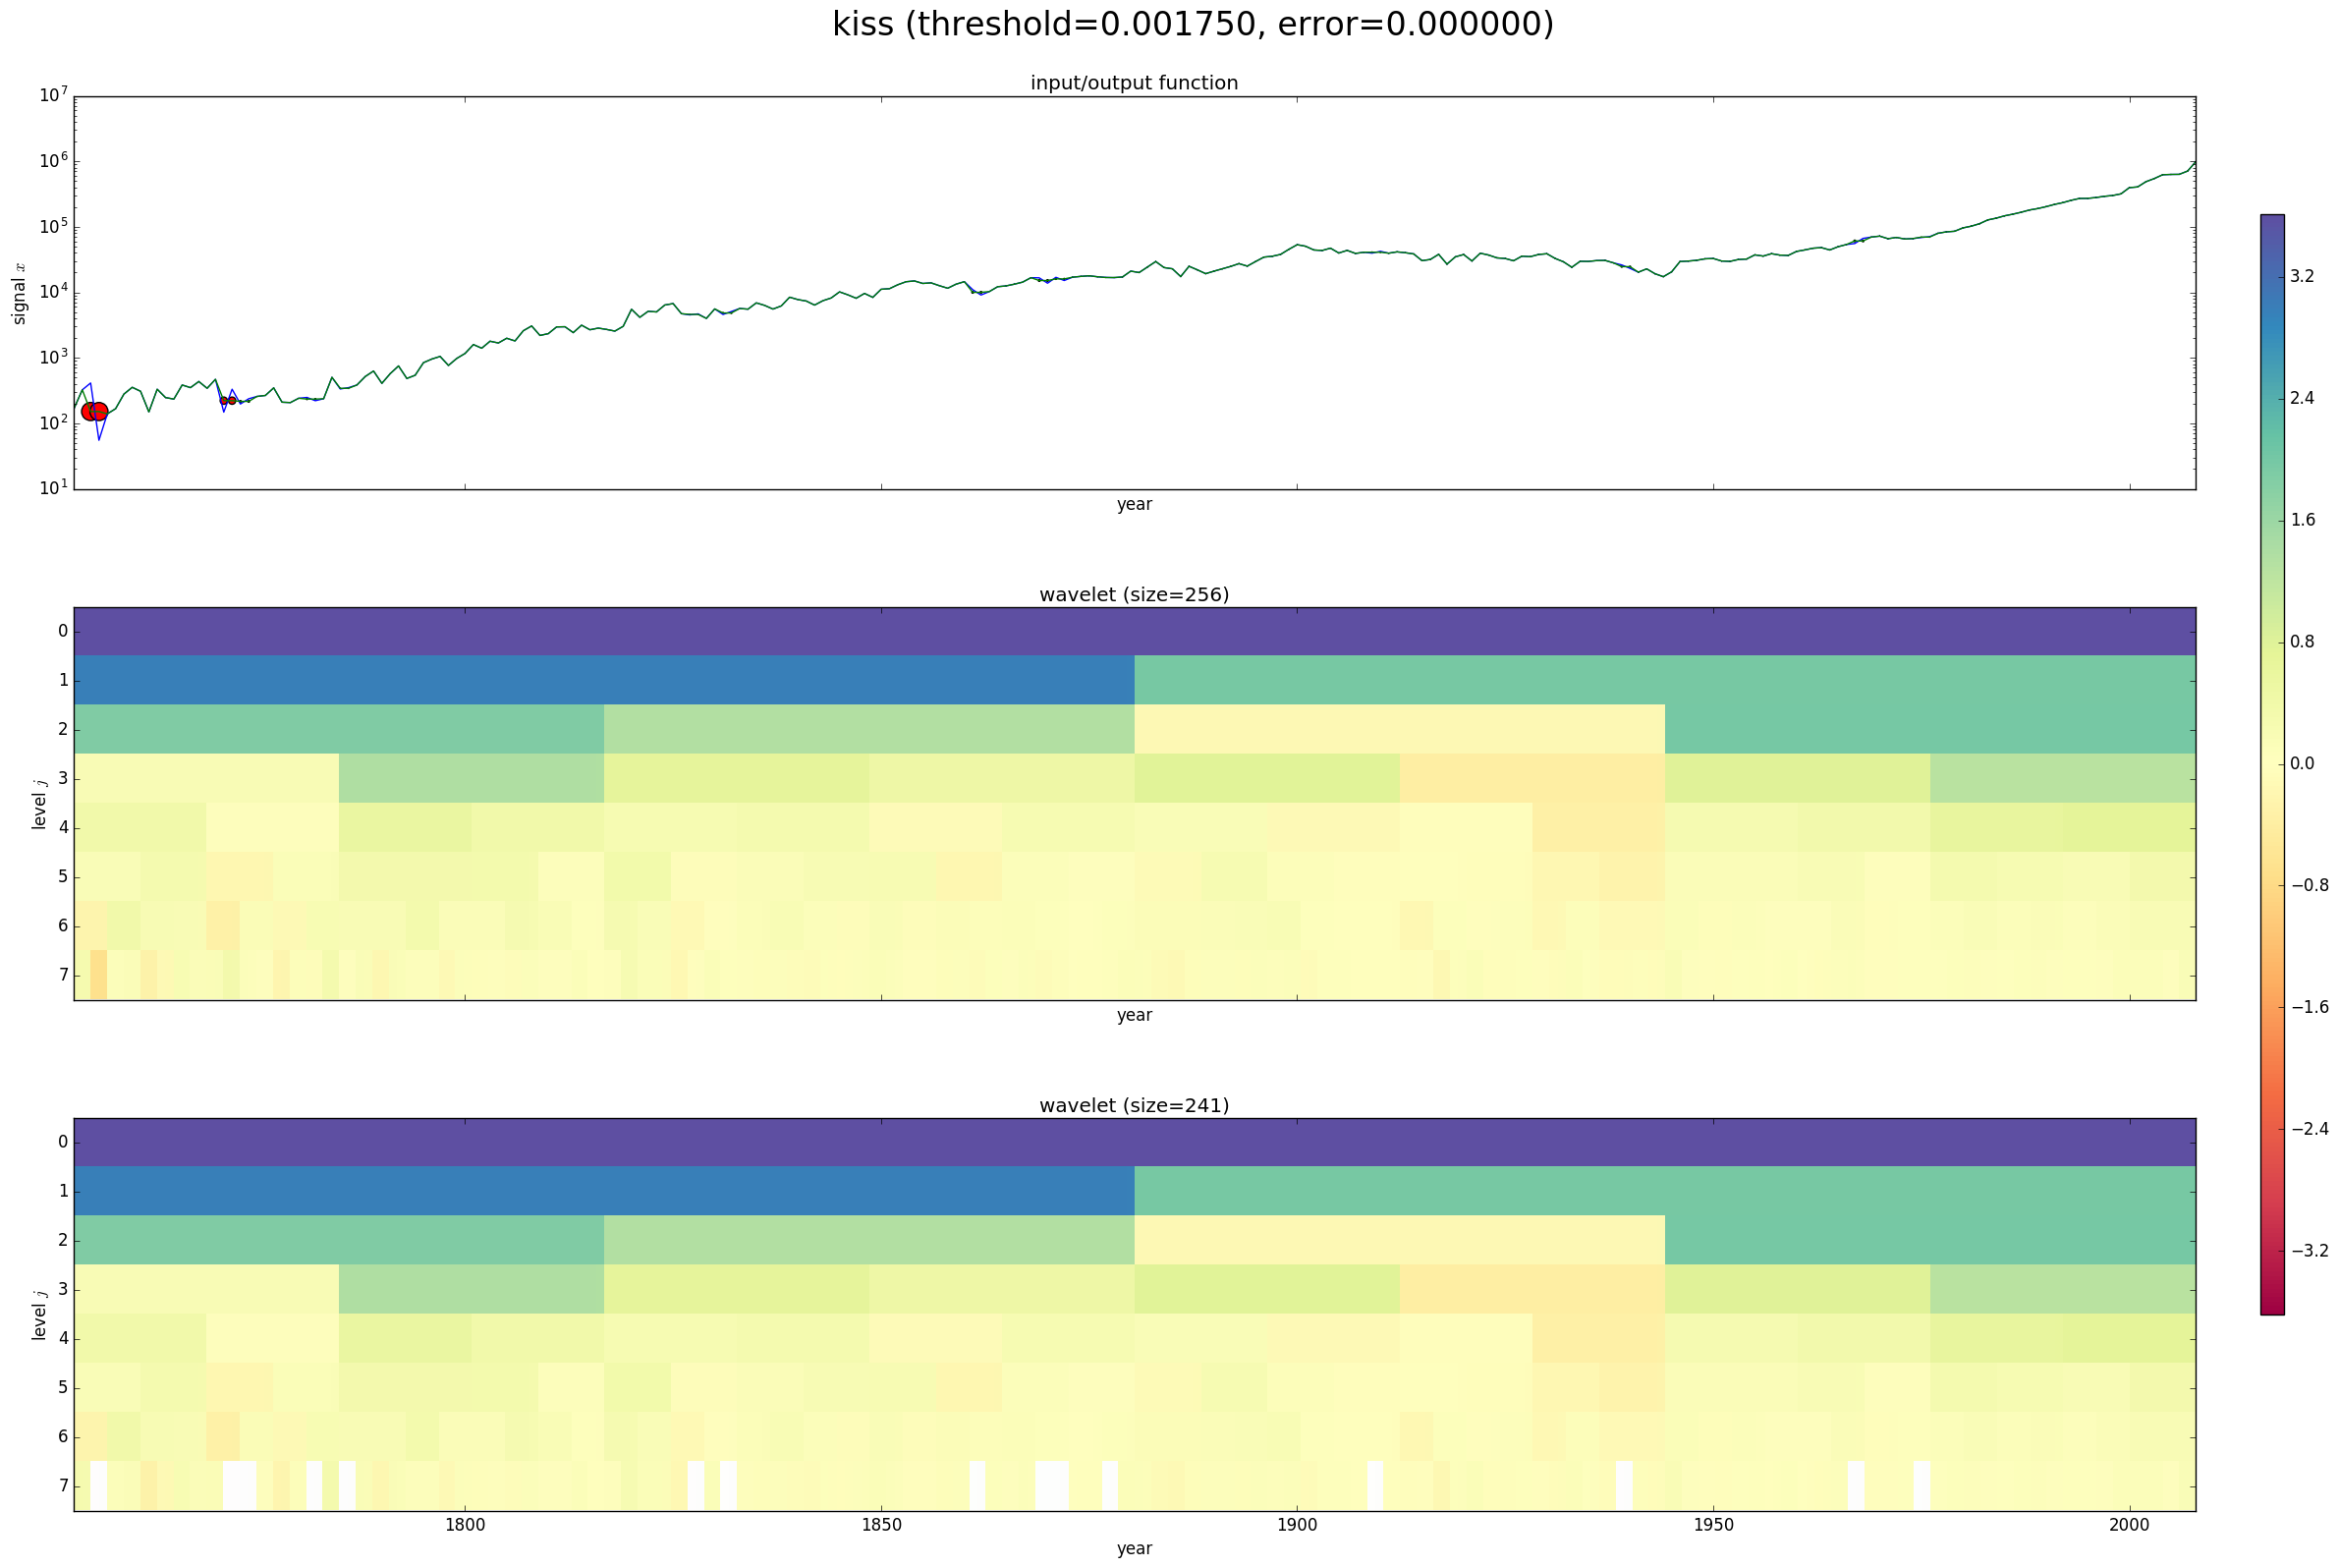

PyObject <matplotlib.text.Text object at 0x7f1faa55b978>

In [9]:
plot_wavelet_report(data, map_s2i, year_first, "kiss", 0.00175, 0, false)

What you can see is that through the random selection, it is very likely that one of the "big" leaves is selected and that there is no error bound left for selecting the noisy but "tiny" leaves. To solve this, we introduce the sorting step.

### Sorted

Now we have a look at the sorted results:

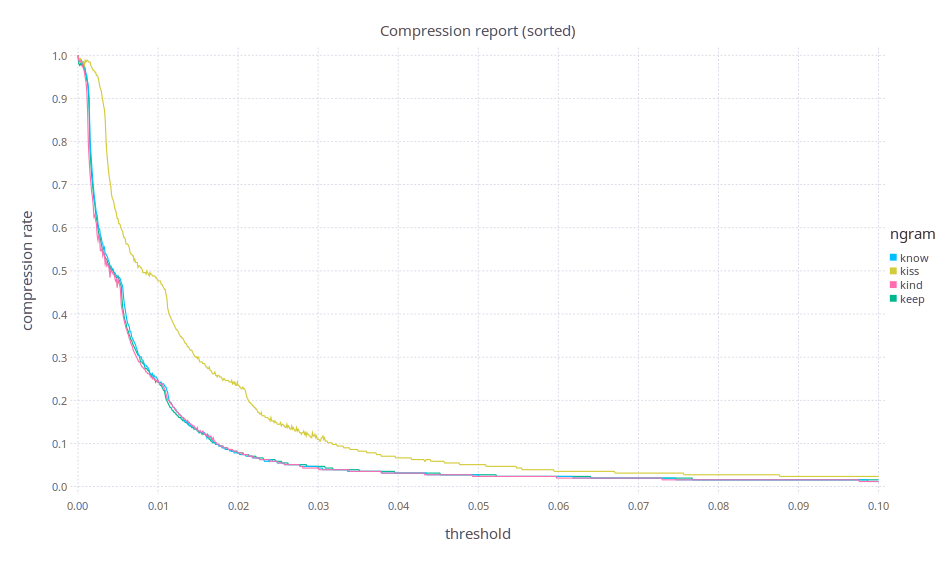

In [20]:
print_compression_report(collect(0:0.0001:0.1), collect(0:0.1:1), true)

To compare:

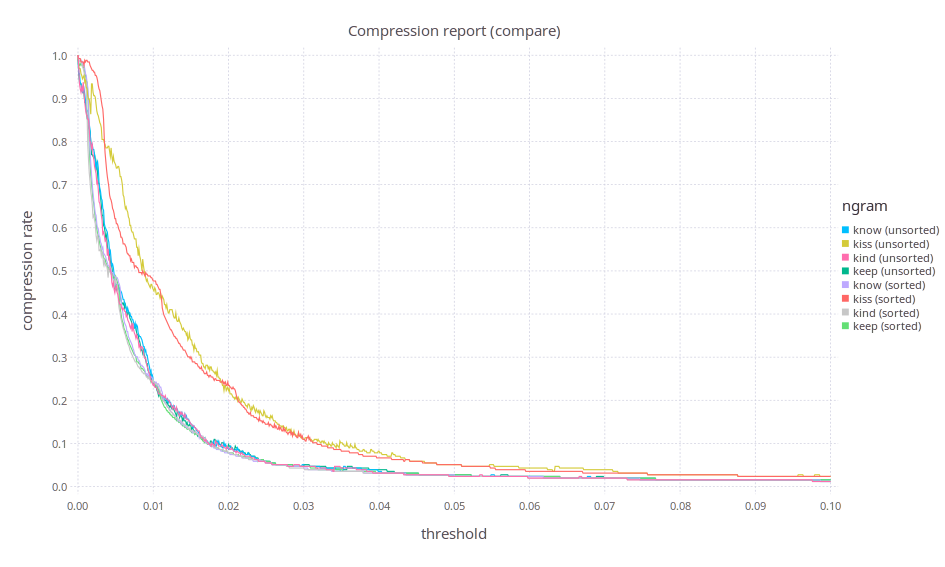

In [21]:
print_compression_report(collect(0:0.0001:0.1), collect(0:0.1:1))

**TODO: sorting is more stable, but is it also BETTER?**

## Tests

Here we show some results of the compression.

In [35]:
wavelet_threshold = 0.01

0.01

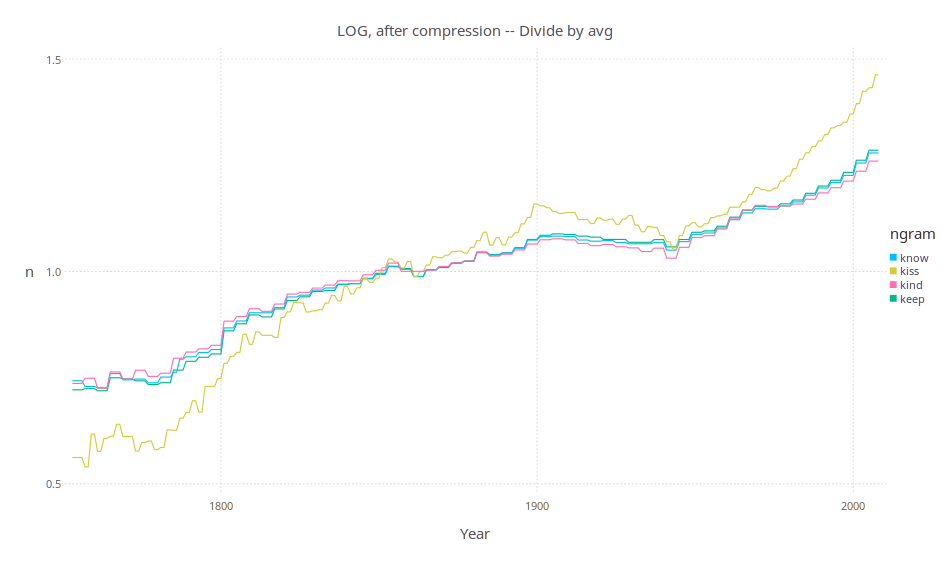

In [36]:
transform_wavelet_log_counter = 0
function transform_wavelet_log(x)
    x_compressed, _, _, xt_compressed = do_wavelet_pruning(x, wavelet_threshold)
    global transform_wavelet_log_counter += count(e -> abs(e) > 0, xt_compressed)
    return log(1.0 + x_compressed)
end
plot_all_that(data, map_s2i, t, ngrams_wavelet_demo, norm_avg, transform_wavelet_log, "LOG, after compression -- Divide by avg")

In [26]:
print("compression rate=", transform_wavelet_log_counter / (length(ngrams_wavelet_demo) * m))

compression rate=0.302734375

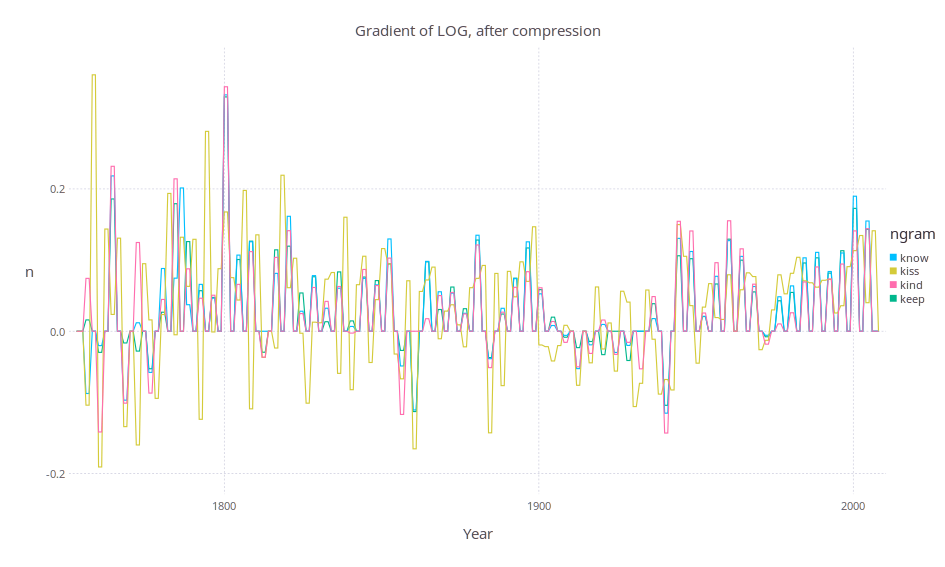

In [28]:
function transform_wavelet_loggradient(x)
    x_compressed, _, _, _ = do_wavelet_pruning(x, wavelet_threshold)
    return transform_loggradient(x_compressed)
end
plot_all_that(data, map_s2i, t, ngrams_wavelet_demo, norm_id, transform_wavelet_loggradient, "Gradient of LOG, after compression")

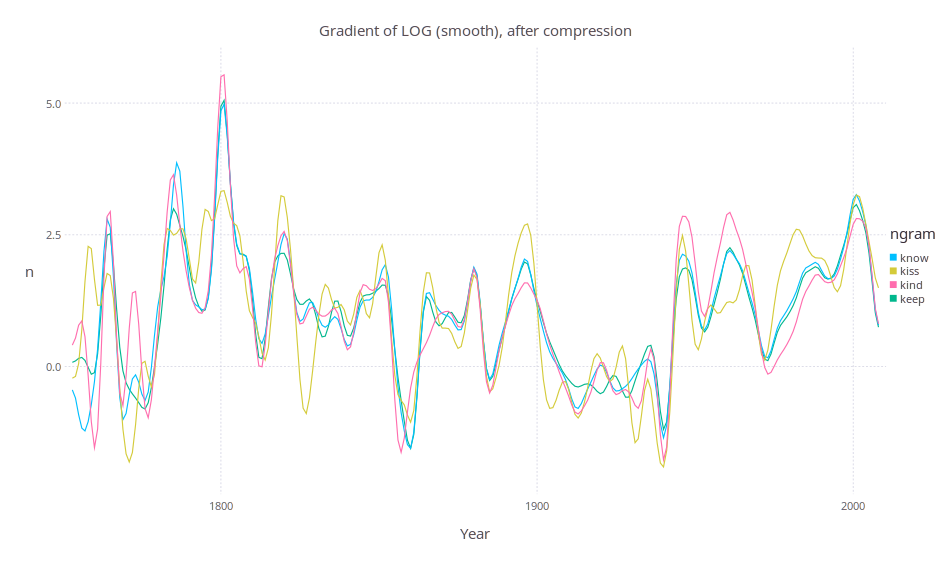

In [29]:
function transform_wavelet_loggradient_smooth(x)
    x_compressed, _, _, _ = do_wavelet_pruning(x, wavelet_threshold)
    return transform_loggradient_smooth(x_compressed)
end
plot_all_that(data, map_s2i, t, ngrams_wavelet_demo, norm_avg, transform_wavelet_loggradient_smooth, "Gradient of LOG (smooth), after compression")

Todos:

- Test how compression affects DTW results
- extend the simple pruning to a tree merging approach